# Iterate Averaged Gradient Methods

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import collections

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
!pip install torchcontrib
from torchcontrib.optim import SWA
import torchcontrib

  Created wheel for torchcontrib: filename=torchcontrib-0.0.2-cp37-none-any.whl size=7532 sha256=c104d8834ad0348b4c412192c8674abc48b4a80538d56e2de42301710f27ee2b
  Stored in directory: /root/.cache/pip/wheels/06/06/7b/a5f5920bbf4f12a2c927e438fac17d4cd9560f8336b00e9a99
Successfully built torchcontrib


# CIFAR 10 Data Classification

### Loading the data

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=124,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=124,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Simple Convolutional Neural Network

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Polyak and Rupert Weights Averaging

In [44]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-1)

In [45]:
losses=[]
iteration = 1.0
old_params={}
for name, params in model.named_parameters():
            old_params[name] = params

for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
  
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # at each step, extract the weights of the model, and add them to previous step weights
        with torch.no_grad():
          for name, params in model.named_parameters():
              old_params[name] = old_params[name] + params


        iteration += 1

        # print statistics
        running_loss += loss.item()
        losses.append(loss.item())
        if i % 200 == 199:    # print every 2000 mini-batches
            print('Epoch: %d, Minibatch: %5d, loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

Epoch: 1, Minibatch:   200, loss: 2.256
Epoch: 1, Minibatch:   400, loss: 1.876
Epoch: 2, Minibatch:   200, loss: 1.665
Epoch: 2, Minibatch:   400, loss: 1.566
Epoch: 3, Minibatch:   200, loss: 1.474
Epoch: 3, Minibatch:   400, loss: 1.428
Epoch: 4, Minibatch:   200, loss: 1.352
Epoch: 4, Minibatch:   400, loss: 1.324
Epoch: 5, Minibatch:   200, loss: 1.266
Epoch: 5, Minibatch:   400, loss: 1.238
Epoch: 6, Minibatch:   200, loss: 1.202
Epoch: 6, Minibatch:   400, loss: 1.165
Epoch: 7, Minibatch:   200, loss: 1.126
Epoch: 7, Minibatch:   400, loss: 1.122
Epoch: 8, Minibatch:   200, loss: 1.068
Epoch: 8, Minibatch:   400, loss: 1.066
Epoch: 9, Minibatch:   200, loss: 1.025
Epoch: 9, Minibatch:   400, loss: 1.027
Epoch: 10, Minibatch:   200, loss: 0.970
Epoch: 10, Minibatch:   400, loss: 0.979
Finished Training


In [46]:
# divide by the number of iterations to get average 
for key in old_params.keys():
  old_params[key] = old_params[key] / iteration

# manually switch the weights of the model
model_average = Net().to(device)
model_average.load_state_dict(old_params)

<All keys matched successfully>

In [47]:
correct = 0
correct_average = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs_average = model_average(inputs)
        outputs = model(inputs)
        _, predicted_average = torch.max(outputs_average.data, 1)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct_average += (predicted_average == labels).sum().item()
        correct += (predicted == labels).sum().item()

print('Test Accuracy using SGD: %d %%' % (100 * correct / total))
print('Test Accuracy using Weights Averaging: %d %%' % (100 * correct_average / total))

Test Accuracy using SGD: 51 %
Test Accuracy using Weights Averaging: 57 %


# Tail Averaging

In [ ]:
criterion = nn.CrossEntropyLoss()

tau_max = 50000/124*10; print("Max number of iterations: ", np.floor(tau_max)) #nb of train images/ batchsize * epoch 
tau_list = [500, 1000, 1500, 2000, 2500, 3000, 3250, 3500, 3750, 4000]
best_accuracy = 0
best_tau = 0
best_weigths = {}

accs_tail = []

Max number of iterations:  4032.0


In [ ]:
# the best tau is selected by cross validation
for t in tau_list:

  model = Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=1e-1)
  #optimizer = optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-3)

  iteration = 1.0
  old_params={}
  for name, params in model.named_parameters():
              old_params[name] = params

  for epoch in range(10):  # loop over the dataset multiple times
      running_loss = 0.0
    
      for i, data in enumerate(trainloader):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data[0].to(device), data[1].to(device)
          # zero the parameter gradients
          optimizer.zero_grad()
          # forward + backward + optimize
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # after threshold tau, at each step, extract the weights of the model, and add them to previous step weights
          if iteration >= t:
            with torch.no_grad():
              for name, params in model.named_parameters():
                  old_params[name] = old_params[name] + params

          iteration += 1
          running_loss += loss.item()

        # print statistics
      print('Epoch: %d, loss: %.3f' % (epoch + 1, running_loss / (50000/124)))
      running_loss = 0.0

  print('Finished Training ')

  # divide by k - tau to have an average over the latest iterations
  for key in old_params.keys():
    old_params[key] = old_params[key] / (iteration - t)
  
  # manually switch the weights of the model
  model_average = Net().to(device)
  model_average.load_state_dict(old_params)

  correct = 0
  correct_average = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          inputs, labels = data[0].to(device), data[1].to(device)
          outputs_average = model_average(inputs)
          _, predicted_average = torch.max(outputs_average.data, 1)
          total += labels.size(0)
          correct_average += (predicted_average == labels).sum().item()
  acc_average = (100 * correct_average / total)
  accs_tail.append(acc_average)
  if acc_average > best_accuracy:
    best_accuracy = acc_average
    best_tau = t
    best_weights = old_params

with torch.no_grad():  
  for data in testloader:
    inputs, labels = data[0].to(device), data[1].to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    correct += (predicted == labels).sum().item()
acc = (100 * correct / total)
print('Test Accuracy using SGD: ', np.round(acc,3))
print('Test Accuracy using Tailed Averaging with tau =', best_tau, ' : ', np.round(best_accuracy,3), '%')


Epoch: 1, loss: 2.083
Epoch: 2, loss: 1.688
Epoch: 3, loss: 1.516
Epoch: 4, loss: 1.394
Epoch: 5, loss: 1.305
Epoch: 6, loss: 1.224
Epoch: 7, loss: 1.156
Epoch: 8, loss: 1.100
Epoch: 9, loss: 1.059
Epoch: 10, loss: 1.012
Finished Training 
Epoch: 1, loss: 2.076
Epoch: 2, loss: 1.632
Epoch: 3, loss: 1.448
Epoch: 4, loss: 1.335
Epoch: 5, loss: 1.246
Epoch: 6, loss: 1.184
Epoch: 7, loss: 1.117
Epoch: 8, loss: 1.060
Epoch: 9, loss: 1.017
Epoch: 10, loss: 0.963
Finished Training 
Epoch: 1, loss: 2.015
Epoch: 2, loss: 1.589
Epoch: 3, loss: 1.432
Epoch: 4, loss: 1.316
Epoch: 5, loss: 1.231
Epoch: 6, loss: 1.164
Epoch: 7, loss: 1.106
Epoch: 8, loss: 1.053
Epoch: 9, loss: 1.006
Epoch: 10, loss: 0.965
Finished Training 
Epoch: 1, loss: 2.028
Epoch: 2, loss: 1.614
Epoch: 3, loss: 1.447
Epoch: 4, loss: 1.334
Epoch: 5, loss: 1.254
Epoch: 6, loss: 1.189
Epoch: 7, loss: 1.124
Epoch: 8, loss: 1.070
Epoch: 9, loss: 1.025
Epoch: 10, loss: 0.981
Finished Training 
Epoch: 1, loss: 2.098
Epoch: 2, loss: 1.

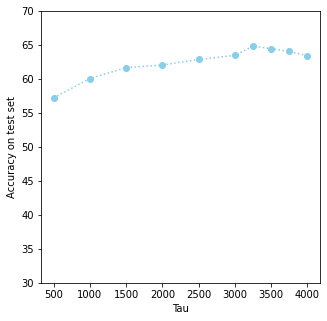

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(tau_list, accs_tail,color = 'skyblue', linestyle=':', marker='o')
plt.xlabel('Tau')
plt.ylabel('Accuracy on test set')
plt.ylim(30,70)

plt.show()

# Geometric Averaging

In [ ]:
criterion = nn.CrossEntropyLoss()

lr = 0.1
lambda_max = 1/lr; print("Lambda max: ",lambda_max) 
lambda_list = np.linspace(0, lambda_max/2, 10) 
best_accuracy = 0
best_lambda = 0
best_weigths = {}

Lambda max:  10.0


In [ ]:
accs_geom = []

In [ ]:
# the best lambda is selected by cross validation
for lambd in lambda_list:

  model = Net().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.1)
  lr = optimizer.param_groups[0]['lr']

  denom = 1
  iteration = 1.0
  old_params={}
  for name, params in model.named_parameters():
              old_params[name] = params

  for epoch in range(10):  # loop over the dataset multiple times
      running_loss = 0.0

      for i, data in enumerate(trainloader):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data[0].to(device), data[1].to(device)
          # zero the parameter gradients
          optimizer.zero_grad()
          # forward + backward + optimize
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

      # at each step, extract the weights of the model, multiply by (1-lr-lambda)**k, and add them to previous step weights
      with torch.no_grad():
        for name, params in model.named_parameters():
            old_params[name] = old_params[name] + params*((1-lr*lambd)**iteration)

      # at each step add (1-lr-lambda)**k
      denom += (1-lr*lambd)**iteration
      iteration += 1
      

      # print statistics
      print('Epoch: %d, loss: %.3f' % (epoch + 1, running_loss / (50000/124)))
      running_loss = 0.0

  print('Finished Training')

  # divide by the sum of (1-lr*lambda)**k
  for key in old_params.keys():
    old_params[key] = old_params[key] / denom

  # manually switch the weights of the model
  model_average = Net().to(device)
  model_average.load_state_dict(old_params)

  correct = 0
  correct_average = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          inputs, labels = data[0].to(device), data[1].to(device)
          outputs_average = model_average(inputs)
          _, predicted_average = torch.max(outputs_average.data, 1)
          total += labels.size(0)
          correct_average += (predicted_average == labels).sum().item()
  acc_average = (100 * correct_average / total)
  accs_geom.append(acc_average)
  
  if acc_average > best_accuracy:
    best_accuracy = acc_average
    best_lambda = lambd
    best_weights = old_params

with torch.no_grad():  
  for data in testloader:
    inputs, labels = data[0].to(device), data[1].to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    correct += (predicted == labels).sum().item()
    acc = (100 * correct / total)
print('Test Accuracy using SGD: ', np.round(acc,3))
print('Test Accuracy using Geometric Averaging with lambda =', best_lambda, ' : ', np.round(best_accuracy,3), '%')

Epoch: 1, loss: 1.995
Epoch: 2, loss: 1.582
Epoch: 3, loss: 1.425
Epoch: 4, loss: 1.325
Epoch: 5, loss: 1.233
Epoch: 6, loss: 1.168
Epoch: 7, loss: 1.112
Epoch: 8, loss: 1.058
Epoch: 9, loss: 1.013
Epoch: 10, loss: 0.977
Finished Training
Epoch: 1, loss: 2.078
Epoch: 2, loss: 1.667
Epoch: 3, loss: 1.486
Epoch: 4, loss: 1.373
Epoch: 5, loss: 1.280
Epoch: 6, loss: 1.206
Epoch: 7, loss: 1.148
Epoch: 8, loss: 1.102
Epoch: 9, loss: 1.054
Epoch: 10, loss: 1.009
Finished Training
Epoch: 1, loss: 2.013
Epoch: 2, loss: 1.615
Epoch: 3, loss: 1.438
Epoch: 4, loss: 1.318
Epoch: 5, loss: 1.232
Epoch: 6, loss: 1.162
Epoch: 7, loss: 1.101
Epoch: 8, loss: 1.048
Epoch: 9, loss: 1.011
Epoch: 10, loss: 0.963
Finished Training
Epoch: 1, loss: 2.010
Epoch: 2, loss: 1.610
Epoch: 3, loss: 1.449
Epoch: 4, loss: 1.343
Epoch: 5, loss: 1.254
Epoch: 6, loss: 1.182
Epoch: 7, loss: 1.123
Epoch: 8, loss: 1.065
Epoch: 9, loss: 1.016
Epoch: 10, loss: 0.973
Finished Training
Epoch: 1, loss: 2.016
Epoch: 2, loss: 1.582


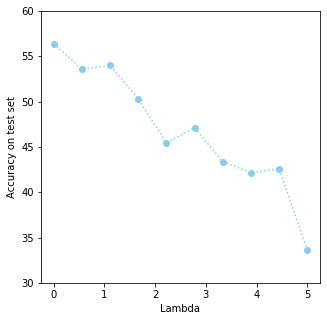

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(lambda_list, accs_geom, color = 'skyblue', linestyle=':', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Accuracy on test set')
plt.ylim(30,60)

plt.show()

# Stochastic Averaging

In [ ]:
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
base_opt = optim.SGD(model.parameters(), lr=0.1)
#base_opt = optim.Adam(model.parameters(), lr=1e-1)
optimizer = torchcontrib.optim.SWA(base_opt, swa_start=3, swa_freq=1, swa_lr=0.05)

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('Epoch: %d, Minibatch: %5d, loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
print('Finished Training')

Epoch: 1, Minibatch:   200, loss: 2.276
Epoch: 1, Minibatch:   400, loss: 1.986
Epoch: 2, Minibatch:   200, loss: 1.805
Epoch: 2, Minibatch:   400, loss: 1.697
Epoch: 3, Minibatch:   200, loss: 1.614
Epoch: 3, Minibatch:   400, loss: 1.555
Epoch: 4, Minibatch:   200, loss: 1.491
Epoch: 4, Minibatch:   400, loss: 1.442
Epoch: 5, Minibatch:   200, loss: 1.396
Epoch: 5, Minibatch:   400, loss: 1.363
Epoch: 6, Minibatch:   200, loss: 1.308
Epoch: 6, Minibatch:   400, loss: 1.308
Epoch: 7, Minibatch:   200, loss: 1.263
Epoch: 7, Minibatch:   400, loss: 1.238
Epoch: 8, Minibatch:   200, loss: 1.219
Epoch: 8, Minibatch:   400, loss: 1.191
Epoch: 9, Minibatch:   200, loss: 1.162
Epoch: 9, Minibatch:   400, loss: 1.153
Epoch: 10, Minibatch:   200, loss: 1.114
Epoch: 10, Minibatch:   400, loss: 1.116
Finished Training


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Test Accuracy using Stochastic Averaging: %f %%' % 100 * correct / total, 3)

In [ ]:
model = Net().to(device)
losses=[]
iteration = 1.0
old_params={}
for name, params in model.named_parameters():
            old_params[name] = params

for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
  
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        if iteration >= 3250:
          with torch.no_grad():
            for name, params in model.named_parameters():
              old_params[name] = old_params[name] + params

        iteration += 1

        # print statistics
        running_loss += loss.item()
        losses.append(loss.item())
        if i % 200 == 199:    # print every 2000 mini-batches
            print('Epoch: %d, Minibatch: %5d, loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

for key in old_params.keys():
  old_params[key] = old_params[key] / iteration

model_average = Net().to(device)
model_average.load_state_dict(old_params)


correct = 0
correct_average = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs_average = model_average(inputs)
        outputs = model(inputs)
        _, predicted_average = torch.max(outputs_average.data, 1)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct_average += (predicted_average == labels).sum().item()
        correct += (predicted == labels).sum().item()

print('Test Accuracy using SGD: %d %%' % (100 * correct / total))
print('Test Accuracy using Weights Averaging: %d %%' % (100 * correct_average / total))